In [6]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pickle as pkl
import json
import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
import google.datalab.storage as storage
import pandas as pd
from io import BytesIO

mybucket = storage.Bucket('heartbeat-233319')
data_csv = mybucket.object('heartrate_db.csv')

uri = data_csv.uri
%gcs read --object $uri --variable data

heart = pd.read_csv(BytesIO(data))
heart.head()

,Time,Value
0,10/1/2017 12:00:00 AM,57
1,10/1/2017 12:00:05 AM,58
2,10/1/2017 12:00:10 AM,58
3,10/1/2017 12:00:20 AM,58
4,10/1/2017 12:00:25 AM,58


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


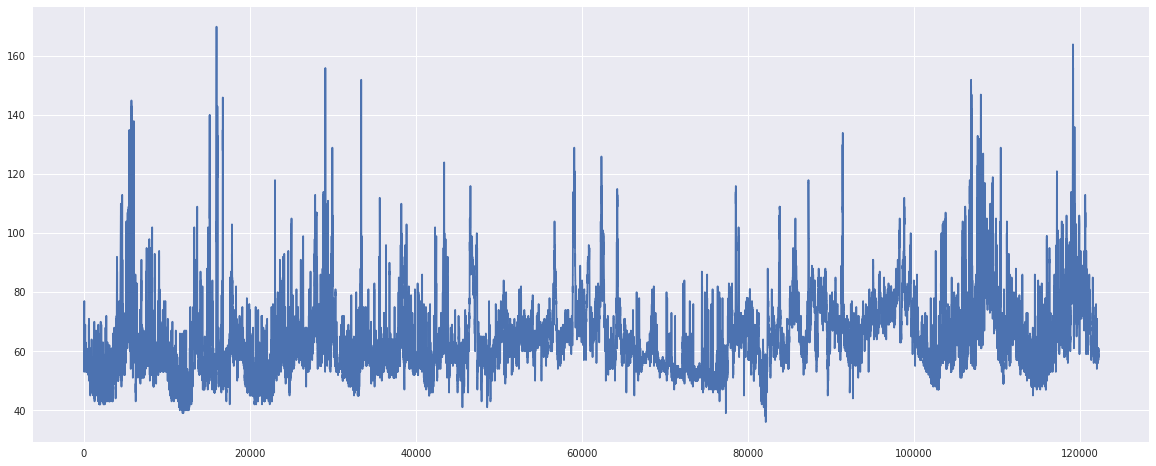

In [11]:
heart_data = heart['Value']
heart_data.plot(figsize = (20,8))

In [12]:
mean = heart_data.mean()
std = heart_data.std()
mean,std

(64.21758407159275, 13.27116097054837)

In [13]:
heart_data = heart_data.apply(lambda x : (x - mean) / std)
heart_data.head()

0   -0.543855
1   -0.468503
2   -0.468503
3   -0.468503
4   -0.468503
Name: Value, dtype: float64

In [14]:
features = []
y = []

window_size = 30
predicted_size = 1

for i in range(heart_data.shape[0] - window_size - predicted_size):
    features.append(heart_data[i:i+window_size])
    y.append(heart_data[i+ window_size])
features, y = np.array(features), np.array(y)
features = np.reshape(features, (features.shape[0], features.shape[1], 1))

In [15]:
split_index = int(features.shape[0]*(1-0.2))
X_train, X_test = features[0:split_index],features[split_index:]
y_train,y_test = y[0:split_index],y[split_index:]

X_train.shape, y_train.shape

((97772, 30, 1), (97772,))

In [16]:
model = Sequential()

model.add(LSTM(units = 30, return_sequences = True, input_shape = (window_size, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 20, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 10, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
model.fit(
    X_train, 
    y_train, 
    epochs = 3, 
    batch_size = 512
)

Epoch 1/3
97772/97772 [==============================] - 63s 647us/step - loss: 0.2316
Epoch 2/3
97772/97772 [==============================] - 60s 614us/step - loss: 0.0847
Epoch 3/3
97772/97772 [==============================] - 60s 612us/step - loss: 0.0644


In [22]:
mybucket = storage.Bucket('heartbeat-233319')
data_csv = mybucket.object('heart.csv')

uri = data_csv.uri
%gcs read --object $uri --variable data

my_heart = pd.read_csv(BytesIO(data),header = None, names = ["Time","Value"])["Value"]
my_heart.head()

0    70
1    70
2    70
3    90
4    91
Name: Value, dtype: int64

In [23]:
my_heart = my_heart.apply(lambda x : (x - mean) / std)
my_heart

0     0.435713
1     0.435713
2     0.435713
3     1.942740
4     2.018091
5     1.641335
6     1.565983
7     1.339929
8     1.264578
9     1.264578
10    1.264578
11    1.415281
12    1.415281
13    1.415281
14    0.737118
15    0.435713
16    0.435713
17    0.435713
18    0.661767
19    0.661767
20    0.661767
21    0.737118
22    0.661767
23    0.661767
24    0.737118
25    0.812470
26    0.812470
27    0.887821
28    0.737118
29    0.812470
30    0.812470
31    0.737118
32    0.737118
33    0.737118
34    0.812470
35    0.812470
36    0.812470
37    0.812470
38    0.887821
39    0.963172
40    1.038524
41    1.038524
42    0.887821
43    0.812470
44    0.812470
45    0.737118
46    0.435713
47    0.435713
48    0.435713
49    0.435713
50    0.435713
51    0.435713
52    0.435713
53    0.435713
54    0.511064
Name: Value, dtype: float64

In [24]:
features = []
y = []

window_size = 30
predicted_size = 1

for i in range(my_heart.shape[0] - window_size - predicted_size):
    features.append(my_heart[i:i+window_size])
    y.append(my_heart[i+ window_size])
features, y = np.array(features), np.array(y)
features = np.reshape(features, (features.shape[0], features.shape[1], 1))

In [25]:
features.shape,y.shape

((24, 30, 1), (24,))

In [26]:
predicted_my_heart = model.predict(features)

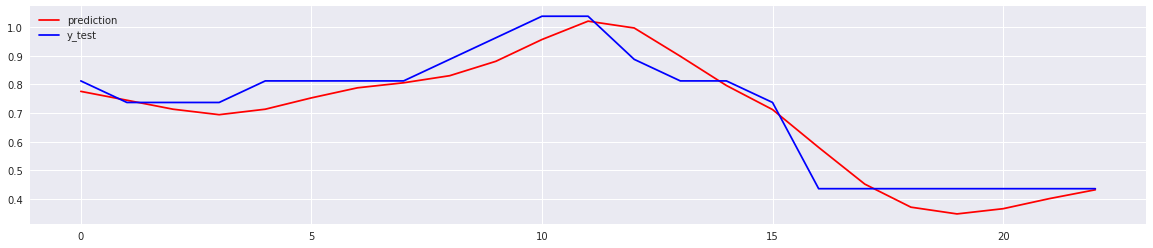

In [27]:
plt.figure(figsize = (20,4))
plt.plot(predicted_my_heart[1:],color='red', label='prediction')
plt.plot(y[:-1],color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [28]:
with open("model.pkl","wb") as f:
  pkl.dump(model,f)

In [29]:
%bash
gsutil cp model.pkl gs://heartbeat-233319/

Copying file://model.pkl [Content-Type=application/octet-stream]...
/ [1 files][365.5 KiB/365.5 KiB]                                                
Operation completed over 1 objects/365.5 KiB.                                    
